# Scaling laws analysis

This notebook contains the scaling laws analysis for AITP. 


**Notation**
- $D_g$ refers to the dataset of general-domain data (or with an abuse of notation, the number of tokens in the dataset of general-domain data).

- $D_s$ is defined similarly for the dataset of math finetuning data.

- $L_m$ is loss on the math data.


There are two main sections:

1. Generating the plot with total steps on the x-axis (Figure 1)

2. Fitting a scaling law to a plot of the loss as a function of $D_g$ and $D_m$ (Figure 2)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
from scipy.optimize import curve_fit
plt.style.use('ggplot')


# Section 1: Generating the plot with total steps on the x-axis (Figure 1)

## Load data


- Row: identified by `Step`, which is $D_g + D_m(t)$, where $t$ is the current step of finetuning.
- Column: identified by a number in {64, 128, 256, ...}, which is the number of pretraining steps. Concretely, this was the number of steps that the Pythia checkpoint was trained on.

In [14]:
df = pd.read_csv('wand_export.csv')
substrings = ["MAX", "MIN"]
keep_cols = [col for col in df.columns 
             if not any(sub in col for sub in substrings)]
df = df.loc[:, keep_cols]
rename_dict = {col: col.split('-')[2] 
               for col in df.columns if col != 'Step'}
df = df.rename(columns=rename_dict)
df

,Step,71000,12000,24000,48000,6000,1000,2000,128,256,64,8
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.098641
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.930866
2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.822045
3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.658034
4,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.542868
...,...,...,...,...,...,...,...,...,...,...,...,...
7258,71996,1.437879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7259,71997,1.494968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7260,71998,1.452195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7261,71999,1.527930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Build a `pretrain_step -> [datapoint1, ...]` map. 

This lets us access the datapoints associated with each model (i.e., amount of pretraining data $D_g$).

In [3]:
from collections import defaultdict

pretrainstep2datapoints = defaultdict(list)

for col in df.columns:
    if col != "Step":
        columns_to_keep = ["Step", col]
        temp = df[columns_to_keep].dropna().rename(
            columns = {
                "Step": "step", col: "loss"
            })
        dict_repr = temp.to_dict(orient='records')
        pretrainstep2datapoints[int(col)].extend(dict_repr)


pretrainstep2datapoints[71000][:5]

[{'step': 71001, 'loss': 1.5357606410980225},
 {'step': 71002, 'loss': 1.5709205865859983},
 {'step': 71003, 'loss': 1.5572983026504517},
 {'step': 71004, 'loss': 1.6476173400878906},
 {'step': 71005, 'loss': 1.5953515768051147}]

### Plot

Notes
- We smooth the loss using a rolling mean with `window` size of 20 
- `first_step` determines the left-most line in the graph
- For number of pretraining tokens we use `pretrain_step*1024*2048`

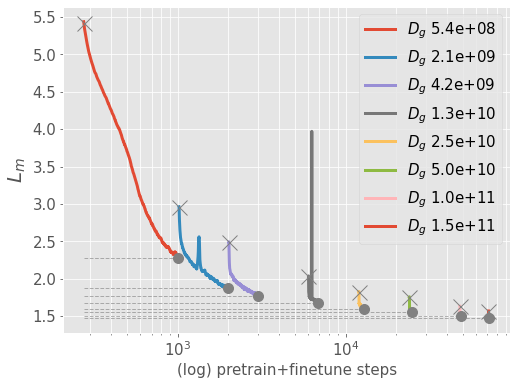

In [4]:
fig, axs = plt.subplots(1, figsize=(8, 6))

window = 20
first_step = 256


pretrainstep2datapoints_ = sorted(pretrainstep2datapoints.items(), key=lambda x: int(x[0]))
for pretrain_step, datapoints in pretrainstep2datapoints_:
    if pretrain_step < first_step:
        continue
    min_x = min([x['step'] for x in pretrainstep2datapoints[first_step]]) + window

    xs = [d['step'] for d in datapoints]
    ys = [d['loss'] for d in datapoints]
    ys = pd.Series(ys).rolling(window).mean().tolist()

    num_pretraining_tokens = pretrain_step*1024*2048
    axs.plot(
        xs, ys, label='$D_g$ %.1e' % (num_pretraining_tokens),
        linewidth=3
    )
    axs.plot(xs[20], ys[20], 'x', color='grey', ms=15)
    axs.plot(xs[-1], ys[-1], 'o', color='grey', ms=10)
    axs.hlines(ys[-1], xmin=min_x, xmax=max(xs), alpha=0.6, color='grey', linestyle='--', linewidth=1)
    
# Labeling and styling
axs.tick_params(axis='both', which='major', labelsize=15)
axs.tick_params(axis='both', which='minor', labelsize=15)

axs.legend(fontsize=15)

axs.set_ylabel("$L_m$", fontsize=20)
axs.set_xlabel("(log) pretrain+finetune steps", fontsize=15)


plt.xscale('log')
# plt.yscale('log')

plt.grid(True, which="both")

plt.savefig('loss_firststep%d.png' % (first_step), bbox_inches='tight', dpi=200)

plt.show()

# Section 2: Fitting a scaling law to loss as a function of $D_g$ and $D_m$ (Figure 2)

## Load data (just to be safe, we do this again)


- Row: identified by `Step`, which is $D_g + D_m(t)$, where $t$ is the current step of finetuning.
- Column: identified by a number in {64, 128, 256, ...}, which is the number of pretraining steps. Concretely, this was the number of steps that the Pythia checkpoint was trained on.

In [5]:
df = pd.read_csv('wand_export.csv')
substrings = ["MAX", "MIN"]
keep_cols = [col for col in df.columns 
             if not any(sub in col for sub in substrings)]
df = df.loc[:, keep_cols]
rename_dict = {col: col.split('-')[2] 
               for col in df.columns if col != 'Step'}
df = df.rename(columns=rename_dict)

#### Convert from steps to tokens

Converts pretraining steps to tokens (`finetune`), using $1024*2048$ tokens per step.

Converts finetuning steps to tokens (`pretrain`), using $128*2048$ tokens per step.

In [6]:
# a datapoint is a triple (pre-train steps, fine-tune steps, loss)
datapoints = []
for col in df.columns: 
    if col != "Step":
        columns_to_keep = ["Step", col]
        temp = df[columns_to_keep].dropna().rename(
            columns = {
                "Step": "finetune", col: "loss"
            })
        temp['finetune'] = temp['finetune'] - temp['finetune'].min() +1
        temp['pretrain'] = int(col)
        temp['finetune'] *= 128*2048
        temp['pretrain'] *= 1024*2048
        dict_repr = temp.to_dict(orient='records')
        datapoints = datapoints + dict_repr

print(datapoints[10], len(datapoints))

{'finetune': 2883584, 'loss': 1.5681257247924805, 'pretrain': 148897792000} 9813


## Collect observations:

- X : ([pre-train tokens] , [fine-tune tokens])
- y : loss


In [7]:
# use 536870912 because it was in the original code
pretrain = 536870912
finetune_tokens = [x["finetune"] for x in datapoints if x["pretrain"] == pretrain and x["finetune"] > 10**1]

# select a subset of `finetune_tokens`. 
# concretely, finetune_tokens[i] is the i'th observation of D_m
interval = 10
max_idx = len(finetune_tokens)-1
index_set = np.arange(0, max_idx, interval)
finetune_tokens = sorted(list([finetune_tokens[i] for i in index_set]))

cache = defaultdict(list)

X = []
y = []
for dm_i in sorted(list(finetune_tokens)): 
    temp_datapoints = sorted(datapoints, key=lambda x: x["pretrain"])
    dgs = [
        x["pretrain"] for x in temp_datapoints if 
        x["finetune"]==dm_i and x["pretrain"]
    ]
    
    dm_cache = []
    dg_cache = []
    for dg_j in dgs:
        dm_cache.append(float(dm_i))
        dg_cache.append(float(dg_j))
        X.append([dm_i, dg_j])
    
    losses = [
        x["loss"] for x in temp_datapoints if 
        x["finetune"]==dm_i and x["pretrain"]
    ] 
    y.extend(losses)

    cache['Dm'].append(np.array(dm_cache))
    cache['Dg'].append(np.array(dg_cache))
    cache['Lm'].append(losses)
    
    
X = ([x[0] for x in X], [x[1] for x in X])

#### Define the scaling law function

In [8]:
def scaling_law(DmDg, C1, C2, C3, C4, alpha_mg, alpha_m):
    Dm, Dg = DmDg
    N = 1.4e9
    return C1 + C2/((Dm + Dg)**alpha_mg) + C3/((1 + (C4*Dm)**alpha_m))

# just for printing convenience
param_names = ['C1\t', 'C2\t', 'C3\t', 'C4\t', 'alpha_mg', 'alpha_m']

#### Do the curve fitting

In [9]:
params, covariance = curve_fit(
    scaling_law, X, y, method='trf'
)

print("Fit parameters:")
for p, name in zip(params, param_names):
    print('  %s\t%.2e' % (name, p))

Fit parameters:
  C1		1.30e+03
  C2		9.19e+03
  C3		-1.30e+03
  C4		1.03e+00
  alpha_mg	4.25e-01
  alpha_m	-3.12e+00


  D_m 2.6e+05	 MSE-first-5 5.4738	MSE-last-5 0.0038
  D_m 2.1e+07	 MSE-first-5 1.4558	MSE-last-5 0.0008
  D_m 4.2e+07	 MSE-first-5 0.6959	MSE-last-5 0.0005
  D_m 6.3e+07	 MSE-first-5 0.3006	MSE-last-5 0.0007
  D_m 8.4e+07	 MSE-first-5 0.1073	MSE-last-5 0.0029
  D_m 1.1e+08	 MSE-first-5 0.0911	MSE-last-5 0.0018
  D_m 1.3e+08	 MSE-first-5 0.2398	MSE-last-5 0.0016
  D_m 1.5e+08	 MSE-first-5 0.4904	MSE-last-5 0.0026
  D_m 1.7e+08	 MSE-first-5 0.7139	MSE-last-5 0.0014
  D_m 1.9e+08	 MSE-first-5 0.7608	MSE-last-5 0.0025


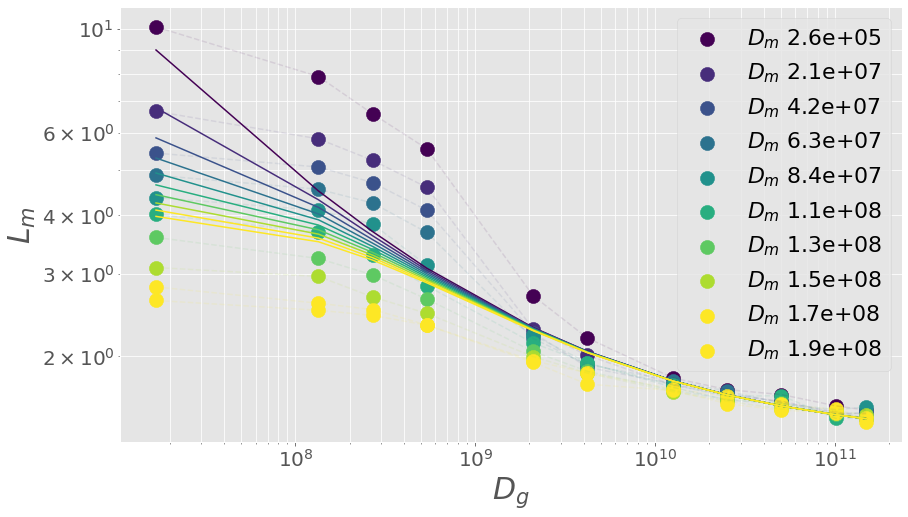

In [10]:
Dm_list = cache['Dm']
Dg_list = cache['Dg']
L_list = cache['Lm']

fig, ax = plt.subplots(1, figsize=(14, 8))

color_map = cm.get_cmap('viridis', len(Dm_list)//8)
color_ctr = 0

for i in range(len(Dm_list))[::8]:
    L_fit = scaling_law((Dm_list[i], Dg_list[i]), *params)
    
   
    color = color_map(color_ctr)

    ax.plot(Dg_list[i], L_fit, color=color)

    ax.scatter(Dg_list[i], L_list[i], label='$D_m$ {:.1e}'.format(Dm_list[i][0]), color=color, s=200)

    ax.plot(Dg_list[i], L_list[i], alpha=0.1, linestyle='--', color=color)
    
    print('  D_m {:.1e}\t MSE-first-5 {:.4f}\tMSE-last-5 {:.4f}'.format(
        Dm_list[i][0],
        np.mean((L_list[i][:5] - L_fit[:5]) ** 2),
        np.mean((L_list[i][-5:] - L_fit[-5:]) ** 2)
    ))

    color_ctr += 1

plt.xscale('log')
plt.yscale('log')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('$D_g$', fontsize=30)
plt.ylabel('$L_m$', fontsize=30)
plt.legend(fontsize=22)
plt.grid(True, which="both")

plt.savefig('loss_fit.png', bbox_inches='tight', dpi=200)

plt.show()

# Archive

[16777216, 134217728, 268435456, 536870912, 2097152000, 4194304000, 12582912000, 25165824000, 50331648000, 100663296000, 148897792000]


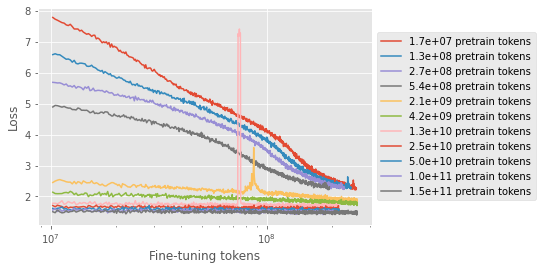

In [11]:
pretrain_values = set(x["pretrain"] for x in datapoints)
print(sorted(list(pretrain_values)))
plt.style.use('ggplot')

for pretrain in sorted(list(pretrain_values)): 
    finetunes = [x["finetune"] for x in datapoints if 
                x["pretrain"]==pretrain and x["finetune"]>10**7]
    losses = [x["loss"] for x in datapoints if 
                x["pretrain"]==pretrain and x["finetune"]>10**7]
    
    plt.plot(finetunes, losses, label="{:.1e} pretrain tokens".format(pretrain))

plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Fine-tuning tokens')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('ex1.png', bbox_inches='tight')
plt.show()



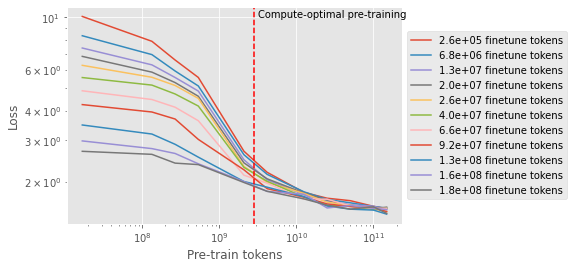

In [12]:
finetunes = [x["finetune"] for x in datapoints if x["pretrain"]==536870912 and x["finetune"]>10**1]
finetune_i = [0, 25, 50, 75, 100, 150, 250, 350, 500, 600, 700]
finetune_values = sorted(list([finetunes[i] for i in finetune_i]))

plt.style.use('ggplot')

for finetune in sorted(list(finetune_values)): 
    temp_datapoints = sorted(datapoints, key=lambda x: x["pretrain"])
    pretrains = [x["pretrain"] for x in temp_datapoints if 
                x["finetune"]==finetune and x["pretrain"]]
    losses = [x["loss"] for x in temp_datapoints if 
                x["finetune"]==finetune and x["pretrain"]]
    
    plt.plot(pretrains, losses, label="{:.1e} finetune tokens".format(finetune))

plt.axvline(x=2.8*10**9, color='red', linestyle='--')
plt.text(3.2*10**9, 10, 'Compute-optimal pre-training', rotation=0)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pre-train tokens')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('ex2.png', bbox_inches='tight')
plt.show()
